In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
from scipy.stats import ttest_ind
import gripql

In [2]:
conn = gripql.Connection("https://bmeg.io/api", credential_file="bmeg_credentials.json")
O = conn.graph("bmeg_rc2")

Look at the expression in the [TCGA LUAD project](https://portal.gdc.cancer.gov/projects/TCGA-LUAD)

In [3]:
PROJECT="Project:TCGA-LUAD"

Starting from the TCGA-LUAD project, follow the edges from `Project` -> `Case` -> `Sample` -> `Aliquot` -> `GeneExpression`. At the `Sample` node, we select from `Solid Tissue Normal` so we only pull the normals during this query.

Once on the gene expression node, extract the `values`, which hold the gene expression values in a Map[String,Float] format with Ensembl Gene ids as the keys, and the Gene expression TPMs as the values. We then load that into a Pandas data frame, and transpose so that the rows are the sample ids.

In [4]:
c = O.query().V(PROJECT).out("cases").out("samples").as_("sample")
c = c.has(gripql.eq("gdc_attributes.sample_type", "Solid Tissue Normal"))
c = c.out("aliquots").out("gene_expressions").as_("exp")
c = c.render( ["$sample._data.gdc_attributes.submitter_id", "$exp._data.values"])
data = {}
for row in c.execute(stream=True):
    data[row[0]] = row[1]
normalDF = pandas.DataFrame(data).transpose()

[INFO]	2019-07-26 20:44:50,476	59 results received in 12 seconds


Do the Project to Gene Expression traversal again, but this time only select the tumor samples.

In [5]:
c = O.query().V(PROJECT).out("cases").out("samples").as_("sample")
c = c.has(gripql.eq("gdc_attributes.sample_type", "Primary Tumor"))
c = c.out("aliquots").out("gene_expressions").as_("exp")
c = c.render( ["$sample._data.gdc_attributes.submitter_id", "$exp._data.values"])
data = {}
for row in c.execute(stream=True):
    data[row[0]] = row[1]
tumorDF = pandas.DataFrame(data).transpose()

[INFO]	2019-07-26 20:46:41,760	539 results received in 110 seconds


For each gene, run t-test to determine the genes with the most differential expression between the tumor and normal sets.

In [6]:
stats = {}
for gene in tumorDF:
    s = ttest_ind(tumorDF[gene], normalDF[gene])
    stats[gene] = { 'statistic': s.statistic, 'pvalue' : s.pvalue }
statsDF = pandas.DataFrame(stats).transpose()

Display the results

In [7]:
statsDF[ statsDF['pvalue'] < 0.0001 ].sort_values('statistic').head()

,pvalue,statistic
ENSG00000168484,6.625251e-227,-53.352962
ENSG00000135604,5.332727e-208,-48.705092
ENSG00000204305,1.356906e-197,-46.256957
ENSG00000114854,1.756643e-188,-44.172306
ENSG00000022267,5.421931e-173,-40.745618


Using the top gene from the T-Test experiment (ENSG00000168484), plot the expression of the gene across the tumor and normal samples

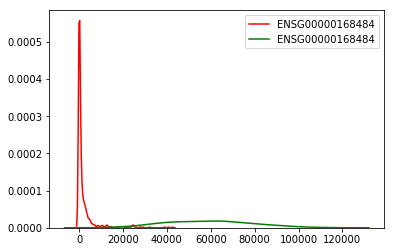

In [8]:
sns.kdeplot(tumorDF['ENSG00000168484'], color="r")
sns.kdeplot(normalDF['ENSG00000168484'], color="g")

Do a quick search of `ENSG00000168484` to identify the Gene Ontology terms that it is linked to

In [9]:
for row in O.query().V("ENSG00000168484").out("gene_ontology_terms"):
    print(row.gid, row.data.definition)

[INFO]	2019-07-26 20:47:15,413	10 results received in 0 seconds


GeneOntologyTerm:GO:0005515 Interacting selectively and non-covalently with any protein or protein complex (a complex of two or more proteins that may include other nonprotein molecules).
GeneOntologyTerm:GO:0005576 The space external to the outermost structure of a cell. For cells without external protective or external encapsulating structures this refers to space outside of the plasma membrane. This term covers the host cell environment outside an intracellular parasite.
GeneOntologyTerm:GO:0005615 That part of a multicellular organism outside the cells proper, usually taken to be outside the plasma membranes, and occupied by fluid.
GeneOntologyTerm:GO:0042599 A membrane-bounded organelle, specialized for the storage and secretion of various substances (surfactant phospholipids, glycoproteins and acid phosphates) which are arranged in the form of tightly packed, concentric, membrane sheets or lamellae. Has some similar properties to, but is distinct from, a lysosome.
GeneOntologyTer